<a href="https://colab.research.google.com/github/apps1990/Apps/blob/master/Copy_of_Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Copyright 2020 Google LLC. Double-click here for license information.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Colabs

Machine Learning Crash Course uses Colaboratories (Colabs) for all programming exercises. Colab is Google's implementation of [Jupyter Notebook](https://jupyter.org/). For more information about Colabs and how to use them, go to [Welcome to Colaboratory](https://research.google.com/colaboratory).

# Binary Classification

So far, you've only created regression models. That is, you created models that produced floating-point predictions, such as, "houses in this neighborhood costs N thousand dollars." In this Colab, you'll create and evaluate a binary [classification model](https://developers.google.com/machine-learning/glossary/#classification_model).  That is, you'll create a model that answers a binary question. In this exercise, the binary question will be, "Are houses in this neighborhood above a certain price?"





## Learning Objectives:

After doing this Colab, you'll know how to:

  * Convert a regression question into a classification question.
  * Modify the classification threshold and determine how that modification influences the model.
  * Experiment with different classification metrics to determine your model's effectiveness.

## The Dataset
  
Like several of the previous Colabs, this Colab uses the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

## Call the import statements

The following code imports the necessary modules.

In [1]:
#@title Load the imports

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Ran the import statements.")

Ran the import statements.


## Load the datasets from the internet

The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set
* `test_df`, which contains the test set

In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

In [3]:
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
4648,-118.1,34.1,34.0,2873.0,718.0,2758.0,699.0,2.6,168600.0
5587,-118.2,33.8,23.0,3768.0,1261.0,3940.0,1098.0,2.0,186200.0
14533,-122.2,37.7,18.0,5778.0,1526.0,2441.0,1352.0,3.2,202700.0
7823,-118.4,34.0,40.0,1565.0,269.0,826.0,268.0,5.2,485700.0
3795,-117.9,33.9,34.0,1475.0,319.0,698.0,293.0,3.8,186000.0


Unlike some of the previous Colabs, the preceding code cell did not scale the label (`median_house_value`).  The following section ("Normalize values") provides an alternative approach.

## Normalize values

When creating a model with multiple features, the values of each feature should cover roughly the same range.  For example, if one feature's range spans 500 to 100,000 and another feature's range spans 2 to 12, then the model will be difficult or impossible to train. Therefore, you should
[normalize](https://developers.google.com/machine-learning/glossary/#normalization) features in a multi-feature model.

The following code cell normalizes datasets by converting each raw value (including the label) to its Z-score. A **Z-score** is the number of standard deviations from the mean for a particular raw value. For example, consider a feature having the following characteristics:

  * The mean is 60.
  * The standard deviation is 10.

The raw value 75 would have a Z-score of +1.5:

```
  Z-score = (75 - 60) / 10 = +1.5
```

The raw value 38 would have a Z-score of -2.2:

```
  Z-score = (38 - 60) / 10 = -2.2
```

In [4]:
# Calculate the Z-scores of each column in the training set and
# write those Z-scores into a new pandas DataFrame named train_df_norm.
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Examine some of the values of the normalized training set. Notice that most
# Z-scores fall between -2 and +2.
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
4648,0.7,-0.7,0.4,0.1,0.4,1.2,0.5,-0.7,-0.3
5587,0.7,-0.9,-0.4,0.5,1.7,2.2,1.6,-1.0,-0.2
14533,-1.3,1.0,-0.8,1.4,2.3,0.9,2.2,-0.4,-0.0
7823,0.6,-0.8,0.9,-0.5,-0.6,-0.5,-0.6,0.7,2.4
3795,0.8,-0.8,0.4,-0.5,-0.5,-0.6,-0.5,-0.0,-0.2


In [5]:
# Calculate the Z-scores of each column in the test set and
# write those Z-scores into a new pandas DataFrame named test_df_norm.
test_df_norm = (test_df - train_df_mean) / train_df_std

# Note that we transform the test data with the values calculated from the training set,
# as you should always transform your datasets with exactly the same values.

In [6]:
test_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.2,0.8,-0.1,0.6,0.3,0.1,0.3,1.4,1.2
1,0.6,-0.6,1.1,-0.5,-0.5,-0.5,-0.6,-0.1,-0.3
2,0.9,-0.9,-0.1,0.4,-0.1,0.0,-0.0,1.0,0.5
3,0.6,-0.8,-0.0,-1.2,-1.2,-1.2,-1.3,1.2,1.1
4,-0.1,0.3,-0.8,-0.6,-0.7,-0.5,-0.7,-0.5,-1.1


## Task 1: Create a binary label

In classification problems, the label for every example must be either 0 or 1. Unfortunately, the natural label in the California Housing Dataset, `median_house_value`, contains floating-point values like 80,100 or 85,700 rather than 0s and 1s, while the normalized version of `median_house_values` contains floating-point values primarily between -3 and +3.

Your task is to create a new column named `median_house_value_is_high` in both the training set and the test set . If the `median_house_value` is higher than a certain arbitrary value (defined by `threshold`), then set `median_house_value_is_high` to 1. Otherwise, set `median_house_value_is_high` to 0.

**Hint:** The cells in the `median_house_value_is_high` column must each hold `1` and `0`, not `True` and `False`. To convert `True` and `False` to  `1` and `0`, call the pandas DataFrame function `astype(float)`.

In [8]:
train_df.median_house_value.mean()

207300.91235294117

In [10]:
train_df.median_house_value.std()

115983.76438720885

In [11]:
threshold = 265000
threshold_norm = (threshold - train_df.median_house_value.mean())/train_df.median_house_value.std()
threshold_norm

0.4974755557547855

In [12]:
threshold = 265000 # This is the 75th percentile for median house values.
train_df_norm["median_house_value_is_high"] = np.where(train_df.median_house_value > threshold, 1, 0) #? Your code here
test_df_norm["median_house_value_is_high"] = np.where(test_df.median_house_value > threshold, 1, 0) #? Your code here

# Print out a few example cells from the beginning and
# middle of the training set, just to make sure that
# your code created only 0s and 1s in the newly created
# median_house_value_is_high column
train_df_norm["median_house_value_is_high"].head(8000)

4648     0
5587     0
14533    0
7823     1
3795     0
        ..
14437    1
8917     0
488      0
4265     0
12130    0
Name: median_house_value_is_high, Length: 8000, dtype: int64

In [ ]:
#@title Double-click for possible solutions.

# We arbitrarily set the threshold to 265,000, which is
# the 75th percentile for median house values.  Every neighborhood
# with a median house price above 265,000 will be labeled 1,
# and all other neighborhoods will be labeled 0.
threshold = 265000
train_df_norm["median_house_value_is_high"] = (train_df["median_house_value"] > threshold).astype(float)
test_df_norm["median_house_value_is_high"] = (test_df["median_house_value"] > threshold).astype(float)
train_df_norm["median_house_value_is_high"].head(8000)


# Alternatively, instead of picking the threshold
# based on raw house values, you can work with Z-scores.
# For example, the following possible solution uses a Z-score
# of +1.0 as the threshold, meaning that no more
# than 16% of the values in median_house_value_is_high
# will be labeled 1.

# threshold_in_Z = 1.0
# train_df_norm["median_house_value_is_high"] = (train_df_norm["median_house_value"] > threshold_in_Z).astype(float)
# test_df_norm["median_house_value_is_high"] = (test_df_norm["median_house_value"] > threshold_in_Z).astype(float)


## Represent features as input layers

This code cell specifies the features, `median_income` and ` total_rooms`, that you'll ultimately train the model on. These [Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input) objects are instantiated as Keras tensors.

In [13]:
inputs = {
# Features used to train the model on.
  'median_income': tf.keras.Input(shape=(1,)),
  'total_rooms': tf.keras.Input(shape=(1,))
}


## Define functions that build and train a model

The following code cell defines two functions:

  * `create_model(inputs, learning_rate, METRICS)`, which defines the model's
    topography.
  * `train_model(model, dataset, epochs, label_name, batch_size, shuffle)`, uses input features and labels to train the model.

Prior exercises used [ReLU](https://developers.google.com/machine-learning/glossary#ReLU) as the [activation function](https://developers.google.com/machine-learning/glossary#activation-function). By contrast, this exercise uses [sigmoid](https://developers.google.com/machine-learning/glossary#sigmoid-function) as the activation function.

In [14]:
#@title Define the functions that create and train a model.
def create_model(my_inputs, my_learning_rate, METRICS):
  # Use a Concatenate layer to concatenate the input layers into a single tensor.
  # as input for the Dense layer. Ex: [input_1[0][0], input_2[0][0]]
  concatenated_inputs = tf.keras.layers.Concatenate()(my_inputs.values())
  dense = layers.Dense(units=1, name='dense_layer', activation=tf.sigmoid)
  dense_output = dense(concatenated_inputs)
  """Create and compile a simple classification model."""
  my_outputs = {
    'dense': dense_output,
  }
  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.
  model.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=my_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=METRICS)
  return model


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.  Here, we're passing
  # every column in the dataset. Note that the feature_layer will filter
  # away most of those columns, leaving only the desired columns and their
  # representations as features.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


## Define a plotting function

The following [matplotlib](https://developers.google.com/machine-learning/glossary/#matplotlib) function plots one or more curves, showing how various classification metrics change with each epoch.

In [15]:
#@title Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


## Invoke the creating, training, and plotting functions

The following code cell calls specify the hyperparameters, and then invokes the
functions to create and train the model, and then to plot the results.

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['longitude', 'latitude', 'housing_median_age', 'total_bedrooms', 'population', 'households', 'median_house_value'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


170/170 [==============================] - 1s 3ms/step - loss: 1.0876 - accuracy: 0.2488
Epoch 2/20
170/170 [==============================] - 0s 3ms/step - loss: 0.9813 - accuracy: 0.2679
Epoch 3/20
170/170 [==============================] - 0s 3ms/step - loss: 0.8842 - accuracy: 0.3022
Epoch 4/20
170/170 [==============================] - 0s 3ms/step - loss: 0.7988 - accuracy: 0.3585
Epoch 5/20
170/170 [==============================] - 0s 3ms/step - loss: 0.7242 - accuracy: 0.4603
Epoch 6/20
170/170 [==============================] - 0s 3ms/step - loss: 0.6613 - accuracy: 0.6012
Epoch 7/20
170/170 [==============================] - 0s 3ms/step - loss: 0.6085 - accuracy: 0.6862
Epoch 8/20
170/170 [==============================] - 0s 3ms/step - loss: 0.5645 - accuracy: 0.7215
Epoch 9/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5270 - accuracy: 0.7558
Epoch 10/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4959 - accuracy: 0.7942
Epoch 11/2

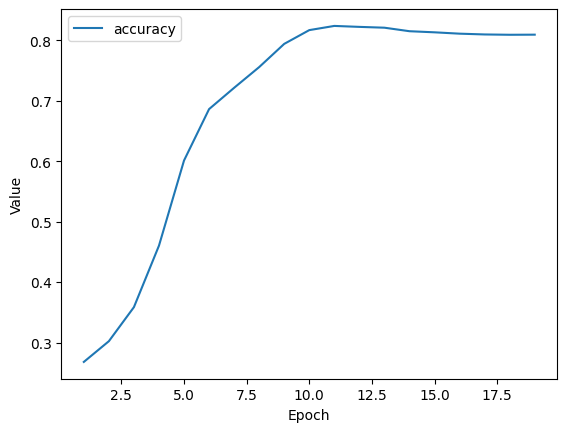

In [16]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy',
                                           threshold=classification_threshold),
          ]

# Establish the model's topography.
my_model = create_model(inputs, learning_rate, METRICS)

# To view a PNG of this model's layers, uncomment the call to
# `tf.keras.utils.plot_model` below. After running this code cell, click
# the file folder on the left, then the `my_classification_model.png` file.
# tf.keras.utils.plot_model(my_model, "my_classification_model.png")

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs,
                           label_name, batch_size)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy']

plot_curve(epochs, hist, list_of_metrics_to_plot)

Accuracy should gradually improve during training (until it can
improve no more).

## Evaluate the model against the test set

At the end of model training, you ended up with a certain accuracy against the *training set*. Invoke the following code cell to determine your model's accuracy against the *test set*.

In [17]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

18/30 [=================>............] - ETA: 0s - loss: 0.4096 - accuracy: 0.8006

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['longitude', 'latitude', 'housing_median_age', 'total_bedrooms', 'population', 'households', 'median_house_value'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


30/30 [==============================] - 0s 3ms/step - loss: 0.4071 - accuracy: 0.8037


[0.4070620536804199, 0.8036666512489319]

## Task 2: How accurate is your model really?

Is your model valuable?

In [ ]:
#@title Double-click for a possible answer to Task 2.

# A perfect model would make 100% accurate predictions.
# Our model makes 80% accurate predictions. 80% sounds
# good, but note that a model that always guesses
# "median_house_value_is_high is False" would be 75%
# accurate.

## Task 3: Add precision and recall as metrics

Relying solely on accuracy, particularly for a class-imbalanced data set (like ours), can be a poor way to judge a classification model.  Modify the code in the following code cell to enable the model to measure not only accuracy but also precision and recall. We have
added accuracy and precision; your task is to add recall. See the [TensorFlow Reference](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall) for details.



In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.35
label_name = "median_house_value_is_high"

# Modify the following definition of METRICS to generate
# not only accuracy and precision, but also recall:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy',
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision'
                                 ),
      ?  # write code here
]

# Establish the model's topography.
my_model = create_model(inputs, learning_rate, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs,
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall']
plot_curve(epochs, hist, list_of_metrics_to_plot)

Epoch 1/20
170/170 [==============================] - 1s 3ms/step - loss: 0.7577 - accuracy: 0.4845 - precision: 0.2890 - recall: 0.7283
Epoch 2/20
170/170 [==============================] - 1s 3ms/step - loss: 0.6768 - accuracy: 0.5671 - precision: 0.3345 - recall: 0.7408
Epoch 3/20
170/170 [==============================] - 1s 3ms/step - loss: 0.6087 - accuracy: 0.6399 - precision: 0.3847 - recall: 0.7363
Epoch 4/20
170/170 [==============================] - 0s 3ms/step - loss: 0.5504 - accuracy: 0.6932 - precision: 0.4315 - recall: 0.7186
Epoch 5/20
170/170 [==============================] - 1s 3ms/step - loss: 0.5043 - accuracy: 0.7342 - precision: 0.4776 - recall: 0.6838
Epoch 6/20
170/170 [==============================] - 1s 3ms/step - loss: 0.4675 - accuracy: 0.7637 - precision: 0.5216 - recall: 0.6551
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4409 - accuracy: 0.7835 - precision: 0.5590 - recall: 0.6315
Epoch 8/20
170/170 [=====================

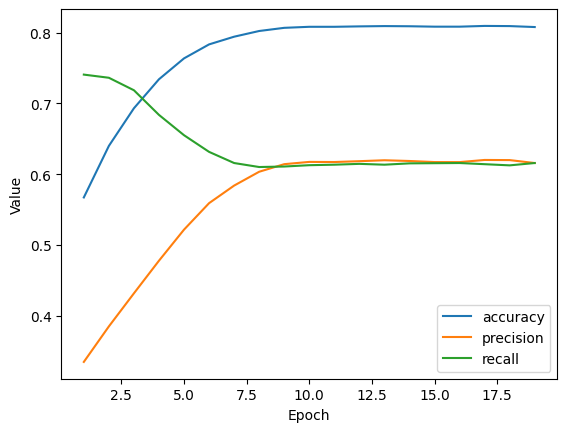

In [18]:
#@title Double-click to view the solution for Task 3.

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.35
label_name = "median_house_value_is_high"

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy',
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision'
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]

# Establish the model's topography.
my_model = create_model(inputs, learning_rate, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs,
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"]
plot_curve(epochs, hist, list_of_metrics_to_plot)


# The new graphs suggest that precision and recall are
# somewhat in conflict. That is, improvements to one of
# those metrics may hurt the other metric.

## Task 4: Experiment with the classification threshold (if time permits)

Experiment with different values for `classification_threshold` in the code cell within "Invoke the creating, training, and plotting functions."  What value of `classification_threshold` produces the highest accuracy?

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['longitude', 'latitude', 'housing_median_age', 'total_bedrooms', 'population', 'households', 'median_house_value'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


170/170 [==============================] - 1s 2ms/step - loss: 0.6992 - accuracy: 0.6826 - precision: 0.3869 - recall: 0.4624
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.6272 - accuracy: 0.7284 - precision: 0.4576 - recall: 0.4719
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5659 - accuracy: 0.7601 - precision: 0.5221 - recall: 0.4690
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5158 - accuracy: 0.7849 - precision: 0.5873 - recall: 0.4679
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4756 - accuracy: 0.8015 - precision: 0.6430 - recall: 0.4617
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4454 - accuracy: 0.8152 - precision: 0.7017 - recall: 0.4526
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4250 - accuracy: 0.8228 - precision: 0.7386 - recall: 0.4497
Epoch 8/20
170/170 [==============================] 

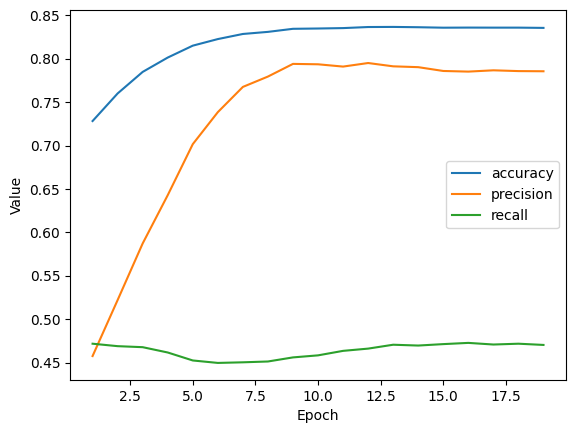

In [19]:
#@title Double-click to view the solution for Task 4.

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.52
label_name = "median_house_value_is_high"

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy',
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision'
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]

# Establish the model's topography.
my_model = create_model(inputs, learning_rate, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs,
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"]
plot_curve(epochs, hist, list_of_metrics_to_plot)

# A `classification_threshold` of slightly over 0.5
# appears to produce the highest accuracy (about 83%).
# Raising the `classification_threshold` to 0.9 drops
# accuracy by about 5%.  Lowering the
# `classification_threshold` to 0.3 drops accuracy by
# about 3%.

## Task 5: Summarize model performance (if time permits)

If time permits, add one more metric that attempts to summarize the model's overall performance.

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['longitude', 'latitude', 'housing_median_age', 'total_bedrooms', 'population', 'households', 'median_house_value'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


170/170 [==============================] - 2s 5ms/step - loss: 1.1407 - auc: 0.2126
Epoch 2/20
170/170 [==============================] - 1s 5ms/step - loss: 0.9996 - auc: 0.2149
Epoch 3/20
170/170 [==============================] - 1s 6ms/step - loss: 0.8751 - auc: 0.2176
Epoch 4/20
170/170 [==============================] - 1s 5ms/step - loss: 0.7672 - auc: 0.2252
Epoch 5/20
170/170 [==============================] - 1s 6ms/step - loss: 0.6774 - auc: 0.2423
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.6059 - auc: 0.3080
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5502 - auc: 0.6678
Epoch 8/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5085 - auc: 0.8291
Epoch 9/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4779 - auc: 0.8322
Epoch 10/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4553 - auc: 0.8319
Epoch 11/20
170/170 [==============================] - 0s 2m

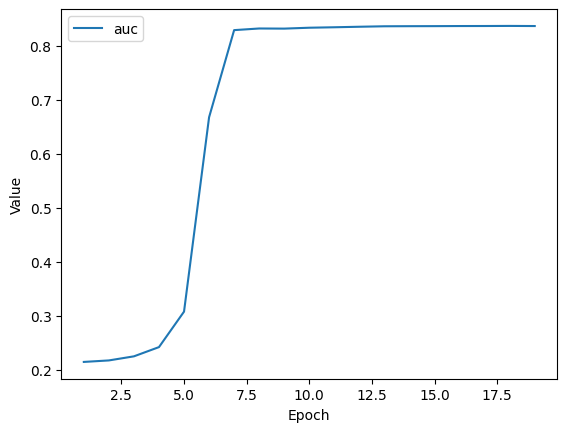

In [20]:
#@title Double-click to view the solution for Task 5.

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"

# AUC is a reasonable "summary" metric for
# classification models.
# Here is the updated definition of METRICS to
# measure AUC:
METRICS = [
      tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
my_model = create_model(inputs, learning_rate, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs,
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['auc']
plot_curve(epochs, hist, list_of_metrics_to_plot)